<div align="center"> 

---

# **Alcohol consumption pattern**

</div>

----

<div align="center"> 

![ModelDesign_IA2BC.png]()

</div>

---
# <u> **Description:**</u>

Alcohol consumption of the rats of the six batches over the four months of the protocol.

---

## **Workflow**

1. Downloading files from drive
2. Data preparation
3. Analyses
4. Exploratory data
5. Visualization

---

**Variables to consider:** 
  - Session
  - Sex  
  
**Metrics**
  - Consumption pattern
  - Alcohol deprivation effect (ADE)
  
**Analysis:**
  - Latent class analysis 

---

### **General settings options**

In [2]:
addTaskCallback(function(...) {set.seed(42);TRUE})
options(warn=-1) # to turn off warnings
#options(warn=0) # to turn on warnings
options(repr.plot.width=12, repr.plot.height=8) # to resize plots

1 
1

## **1. Downloading files from drive**

### **1.1 Autenticate with your google drive credentials** 

Download datasets of the consumption. Run the next two cells and make sure of granting permisions to view, access, and modify google drive files (mark all the tick boxes).

---

In [3]:
library(googledrive)
library(R.utils)
library(httr)

my_check <- function() {return(TRUE)}
  reassignInPackage("is_interactive", pkgName = "httr", my_check) 
  options(rlang_interactive=TRUE)


Loading required package: R.oo

Loading required package: R.methodsS3

R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.25.0 (2022-06-12 02:20:02 UTC) successfully loaded. See ?R.oo for help.


Attaching package: ‘R.oo’


The following object is masked from ‘package:R.methodsS3’:

    throw


The following objects are masked from ‘package:methods’:

    getClasses, getMethods


The following objects are masked from ‘package:base’:

    attach, detach, load, save


R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.


Attaching package: ‘R.utils’


The following object is masked from ‘package:utils’:

    timestamp


The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, warnings




### **1.2 Load  R packages and dependencies.** 

  The following packages are needed for the to move on, firstly it is needed to download pacman library

 ---

In [4]:
# Make sure to install pacman before we begin
  if (!require("pacman")) {
  install.packages("pacman")
  }

# Load required packages  
  pacman::p_load(tidyverse,devtools,ggpubr,ggthemes,SmartEDA,lme4,performance,rstatix,data.table,hablar,cowplot,lcmm,plotrix,report,broom)


Loading required package: pacman



### **1.3 Download files**

Download files from google drive on the following link: 
https://drive.google.com/drive/folders/1D8n_B9wrqthQU2wfoK6iJdbjUXzdUryF

The downloaded files are: 

- datasets 1:6
---

In [5]:
setwd("../")

## **2. Data preparation**

Reading files and set it all up for Alcohol group

In [6]:
suppressMessages(
dataset_alcohol <- list.files(path = paste0(getwd(),"/Data/Datasets"), full.names = T) %>% map(~ .x %>% read_csv()) %>% plyr::rbind.fill() %>% 
  convert(chr(Sex,Session,Phase), num(Age,Weight_kg,EtOH,H2O)) %>%
  filter(Condition_day == "EtOH", Group == "Alc" | Group == "Alc+Str") %>% 
  select(RID,Sex,Session,Age,Weight_kg,Group,Condition,EtOH,H2O,Phase,Batch) %>%
  pivot_longer(cols=c(EtOH, H2O), values_to = "value", names_to = "Bottle") %>%
  pivot_wider(names_from = "Condition",values_from = "value") %>% 
  group_by(Bottle) 
    )

In [7]:
### Important issue: What point to set the NA threshold, that is, how much do the rats drank at 24 hrs ###

Alcohol_thresh <- dataset_alcohol %>% mutate(`24_hrs` = case_when(`24_hrs` >=60 ~ `24_hrs`))

General_intake <- Alcohol_thresh %>% 
  mutate(start_30mins = start - `30_mins`, 
         start_24_hrs = start - `24_hrs`,
         main_intake = (start_24_hrs * Weight_kg),
         basal_start = start - 27, 
         basal_30min = `30_mins` - 27,
         Basal_24hrs = `24_hrs` - 27,
         T_30min = basal_start - basal_30min,
         T_24hrs = basal_start - Basal_24hrs,
         Total_fluid_intake_24 = (T_24hrs * 100)/98.0608,
         Total_fluid_intake_30 = (T_30min * 100)/98.0608,
         Binge = (start_30mins* Weight_kg),
         Preferency = main_intake/Total_fluid_intake_24) 


Alcohol_intake <- General_intake %>% 
  filter(Bottle == "EtOH") %>%
  mutate(Sex = factor(Sex),
         Phase = factor(Phase)) %>% 
  ungroup

In [8]:
AI_extremes <- Alcohol_intake %>% group_by(Group,Session) %>% identify_outliers(main_intake) %>% filter(is.extreme == TRUE) 
AI_extremes_NA <- AI_extremes %>% mutate(main_intake = case_when(main_intake <=12 ~ main_intake )) %>% select(-c(is.outlier,is.extreme))

Alcohol_intake <- Alcohol_intake %>% anti_join(AI_extremes) %>% bind_rows(AI_extremes_NA) 
AI_extremesB <- Alcohol_intake %>% group_by(Group,Session) %>% identify_outliers(Binge) %>% filter(is.extreme == TRUE) 
AI_extremesB_NA <- AI_extremesB %>% mutate(Binge = case_when(Binge <= 5 ~ Binge)) %>% 
                   select(-c(is.outlier,is.extreme))
Alcohol_intake <- Alcohol_intake %>% anti_join(AI_extremesB) %>% bind_rows(AI_extremesB_NA) 

Joining with `by = join_by(RID, Sex, Session, Age, Weight_kg, Group, Phase,
Batch, Bottle, start, `30_mins`, `24_hrs`, start_30mins, start_24_hrs,
main_intake, basal_start, basal_30min, Basal_24hrs, T_30min, T_24hrs,
Total_fluid_intake_24, Total_fluid_intake_30, Binge, Preferency)`
Joining with `by = join_by(RID, Sex, Session, Age, Weight_kg, Group, Phase,
Batch, Bottle, start, `30_mins`, `24_hrs`, start_30mins, start_24_hrs,
main_intake, basal_start, basal_30min, Basal_24hrs, T_30min, T_24hrs,
Total_fluid_intake_24, Total_fluid_intake_30, Binge, Preferency)`


## **3. Analysis**

1. Consumption pattern
    - Latent class analysis
2. Alcohol deprivation effect

### **3.1 Alcohol deprivation effect**

Taken into account the first 3 sessions of alcohol-water 

In [9]:
ADE <- General_intake %>%
  select(RID,Group,Phase,Bottle,main_intake,Session) %>% 
  filter(Phase == "Relapse") %>% na.omit %>%
  pivot_wider(names_from = "Bottle",values_from = "main_intake") %>% 
  mutate(Total_fluid = EtOH + H2O,
          ADE = EtOH / Total_fluid) %>% 
  filter(Session %in% c(1:3))

## **4. Exploratory data**

In [10]:
ExpNumStat(Alcohol_intake,by="A",MesofShape=1,Outlier=TRUE,round=2)
# Low percentage of missing data and outliers

,Vname,Group,TN,nNeg,nZero,nPos,NegInf,PosInf,NA_Value,Per_of_Missing,⋯,min,max,mean,median,SD,CV,IQR,LB.25%,UB.75%,nOutliers
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,24_hrs,All,2588,0,0,2514,0,0,74,2.86,⋯,61.00,128.00,112.67,114.00,7.22,0.06,7.00,99.50,127.50,119
5,30_mins,All,2588,0,0,2543,0,0,45,1.74,⋯,96.00,130.00,118.90,119.00,3.34,0.03,2.00,115.00,123.00,177
2,Age,All,2588,0,0,2588,0,0,0,0.00,⋯,45.00,144.00,85.89,78.00,29.07,0.34,53.00,-17.50,194.50,0
12,Basal_24hrs,All,2588,0,0,2514,0,0,74,2.86,⋯,34.00,101.00,85.67,87.00,7.22,0.08,7.00,72.50,100.50,119
11,basal_30min,All,2588,0,0,2543,0,0,45,1.74,⋯,69.00,103.00,91.90,92.00,3.34,0.04,2.00,88.00,96.00,177
10,basal_start,All,2588,0,0,2542,0,0,46,1.78,⋯,70.00,102.00,93.01,93.00,2.98,0.03,2.00,89.00,97.00,131
17,Binge,All,2588,70,920,1532,0,0,66,2.55,⋯,-1.82,4.85,0.33,0.24,0.49,1.46,0.48,-0.72,1.19,142
9,main_intake,All,2588,2,64,2388,0,0,134,5.18,⋯,-0.26,12.82,2.11,1.59,1.89,0.90,2.15,-2.49,6.10,114
18,Preferency,All,2588,0,0,2405,0,0,183,7.07,⋯,0.07,0.57,0.29,0.27,0.09,0.33,0.13,0.03,0.54,5


## **5. Visualization**

In [11]:
## Settings color and theme

pal_group <- c(alpha("#000000",0.6),"#B22222","#217175")
pal_sex <- c(alpha("#83458E",1),alpha("#28799f",1))
pal_groupSex <- c("#737373","#202020","#4D1857","#184557")
theme_settings <- theme(text = element_text(size=20,family = "Times New Roman"),axis.text.x = element_text(size=18),legend.title=element_blank())

dir.create(path = paste0(getwd(),"/Figures/Consumption"),recursive = T)


### **5.1 Alcohol intake by sex**

#### 5.1.1 Main intake along the whole protocol

In [12]:
plot_mainIntake <- ggline(Alcohol_intake, x = "Session", y =  "main_intake", group = "Sex", point.size = 2,
       add = c("mean_se"), size=2, color = "Sex", facet.by = "Phase", palette = pal_sex,
       ylab = "Main intake (g/kg/24 hrs)", xlab = "Sessions") + theme_settings

#### 5.1.2 Binge along the whole protocol

In [13]:
plot_binge <- ggline(Alcohol_intake, x = "Session", y =  "Binge", group = "Sex", point.size = 2,
       add = c("mean_se"), size=2, color = "Sex", facet.by = "Phase", palette = pal_sex,
       ylab = "Binge (g/kg/30 min)", xlab = "Sessions") + theme_settings

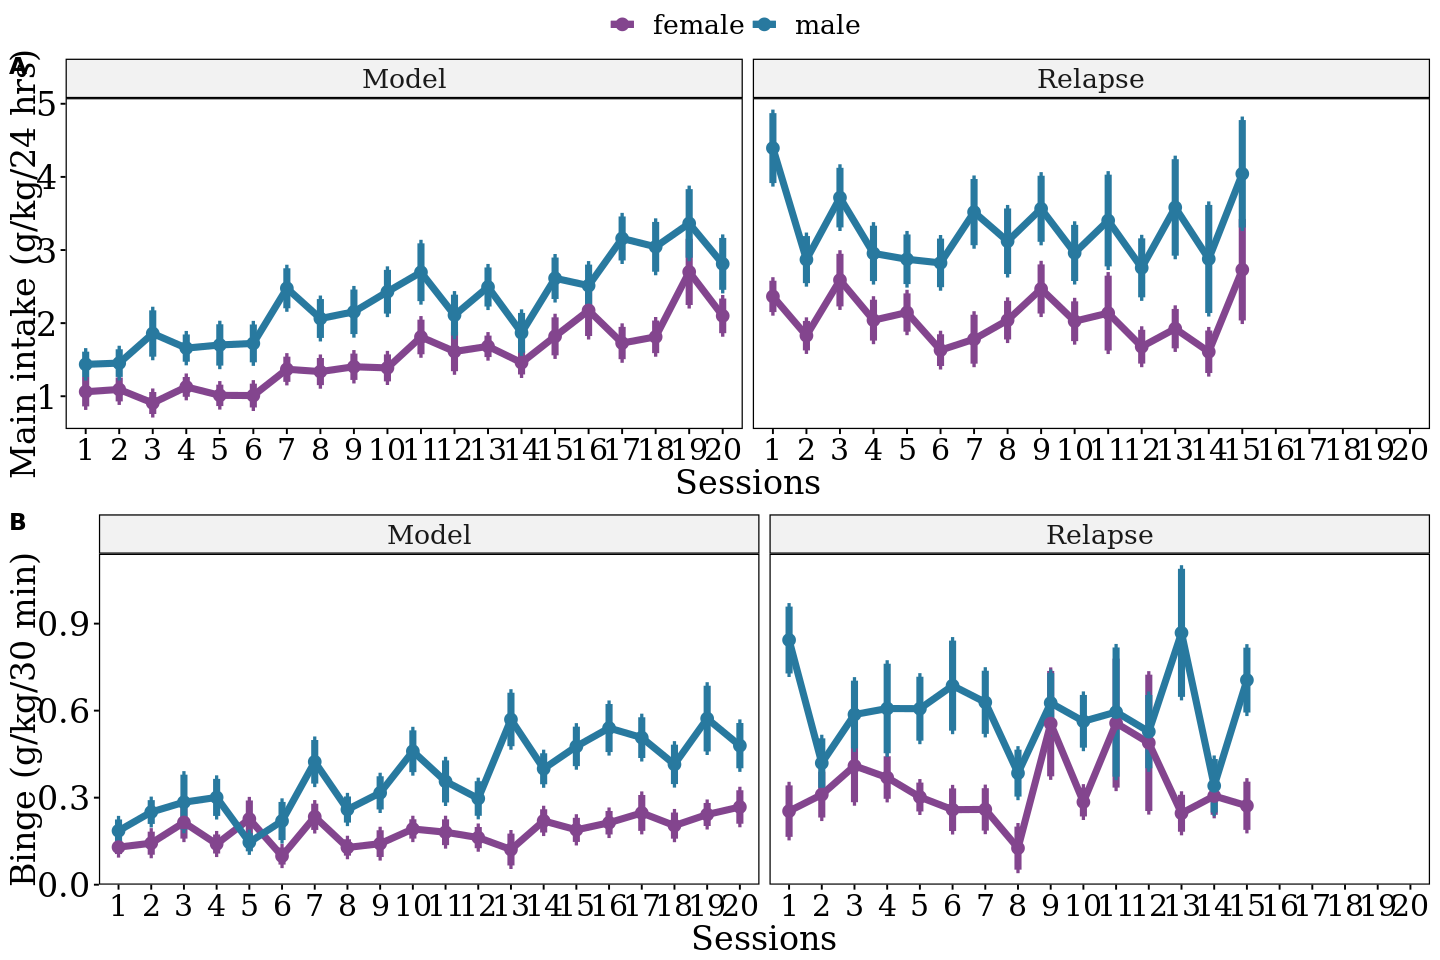

In [14]:
plot_consumption <-  ggarrange(plot_mainIntake, plot_binge, labels = c("A", "B"), ncol = 1, common.legend = T)
plot_consumption

### **5.2 Alcohol intake by consumption pattern**

#### 5.2.1 Main intake along the whole protocol

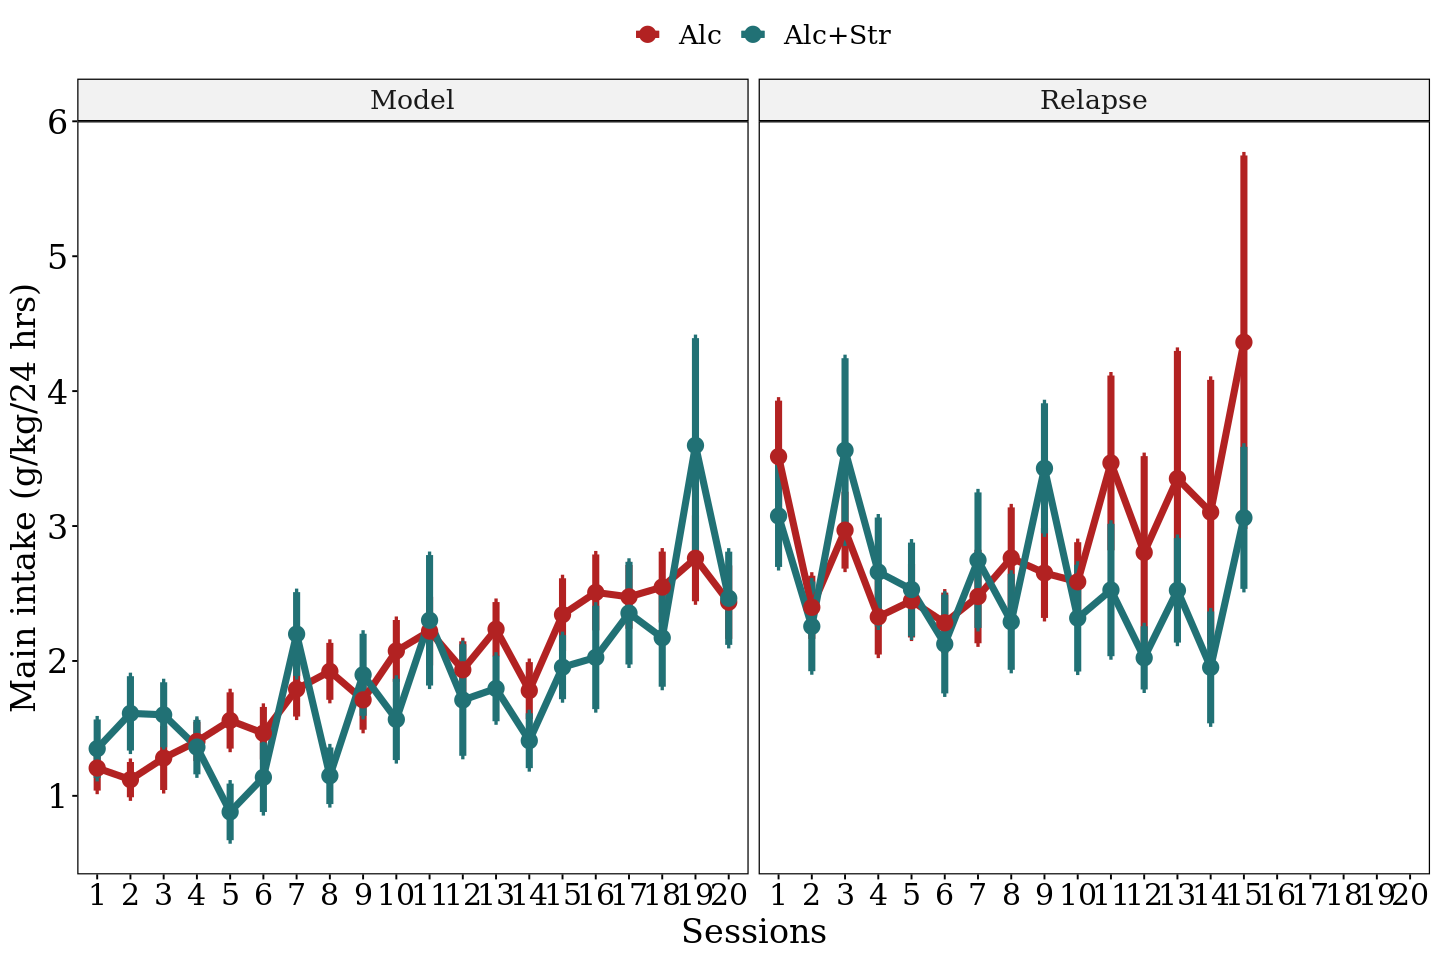

In [15]:
plot_group <- Alcohol_intake %>% 
    ggline(x = "Session", y =  "main_intake", group = "Group", point.size = 3,
           add = c("mean_se"), size=2, color = "Group", facet.by = "Phase", palette = pal_group[2:3],
           legend.title = "Group", 
           ylab = "Main intake (g/kg/24 hrs)", xlab = "Sessions") + theme_settings 
plot_group

In [16]:
plot_groupM <- Alcohol_intake %>% filter(Sex == "male") %>%
    ggline(x = "Session", y =  "main_intake", group = "Group", point.size = 3,
           add = c("mean_se"), size=2, color = "Group", facet.by = "Phase", palette = pal_group[2:3],
           legend.title = "Group", 
           ylab = "Main intake (g/kg/24 hrs)", xlab = "Sessions") + theme_settings 
plot_groupF <- Alcohol_intake %>% filter(Sex == "female") %>%
    ggline(x = "Session", y =  "main_intake", group = "Group", point.size = 3,
           add = c("mean_se"), size=2, color = "Group", facet.by = "Phase", palette = pal_group[2:3],
           legend.title = "Group", 
           ylab = "Main intake (g/kg/24 hrs)", xlab = "Sessions") + theme_settings 

#### 5.2.2 Binge along the whole protocol

In [17]:
plot_group_binge <- Alcohol_intake %>% 
    ggline(x = "Session", y =  "Binge", group = "Group", point.size = 3,
           add = c("mean_se"), size=2, color = "Group", facet.by = "Phase", palette = pal_group[2:3],
           legend.title = "Group", 
           ylab = "Binge (g/kg/30 min)", xlab = "Sessions") + theme_settings

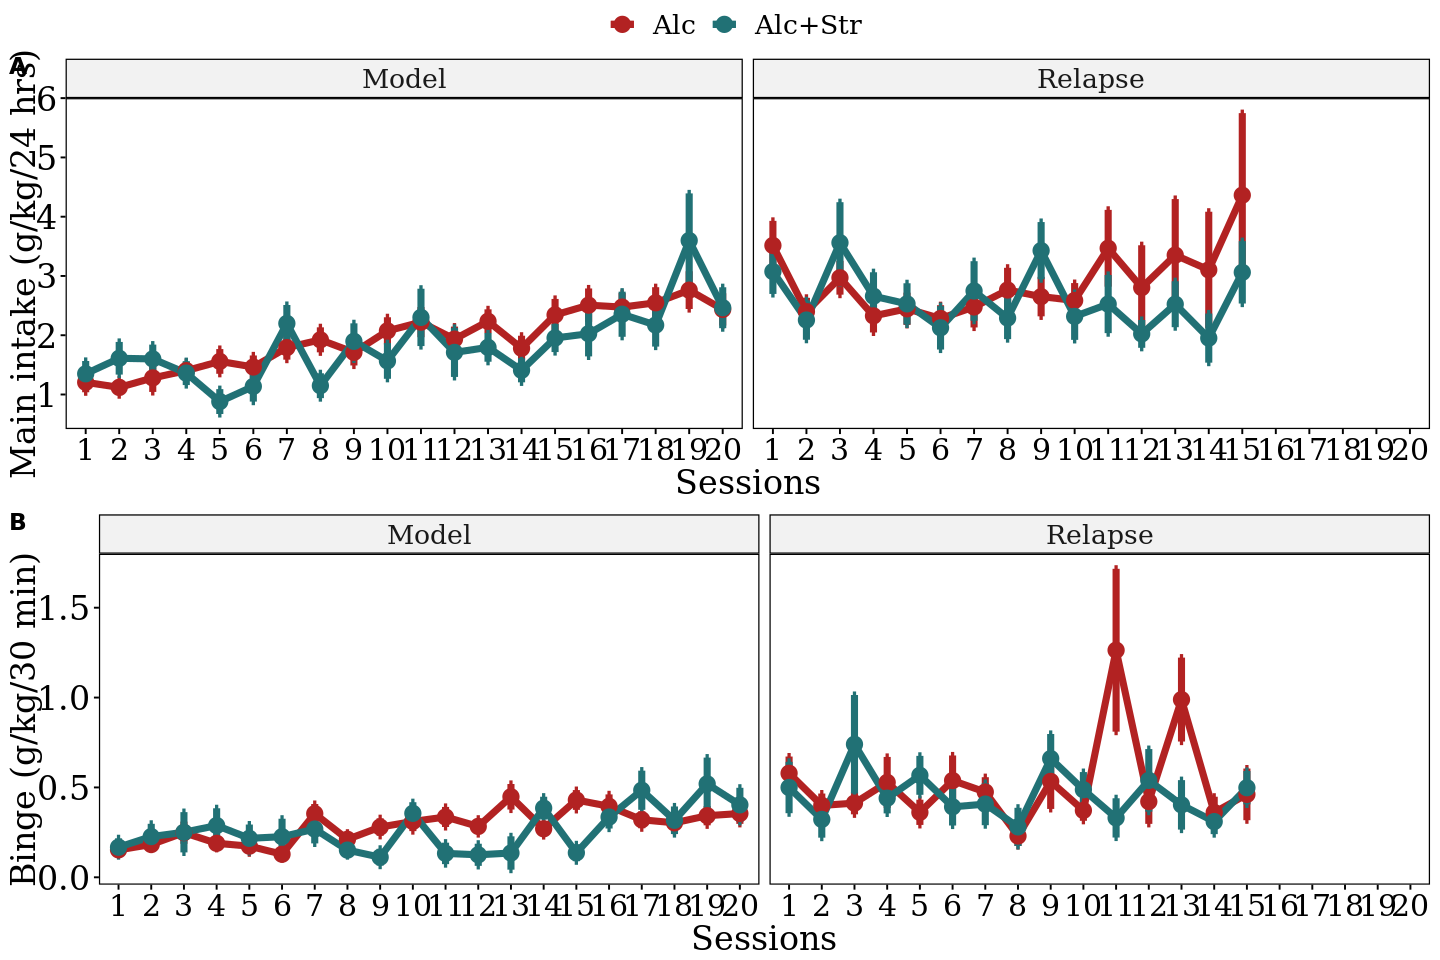

In [18]:
plot_clss_consumption <-  ggarrange(plot_group, plot_group_binge, labels = c("A", "B"), ncol = 1, common.legend = T)
plot_clss_consumption

#### **5.3 Alcohol deprivation effect**

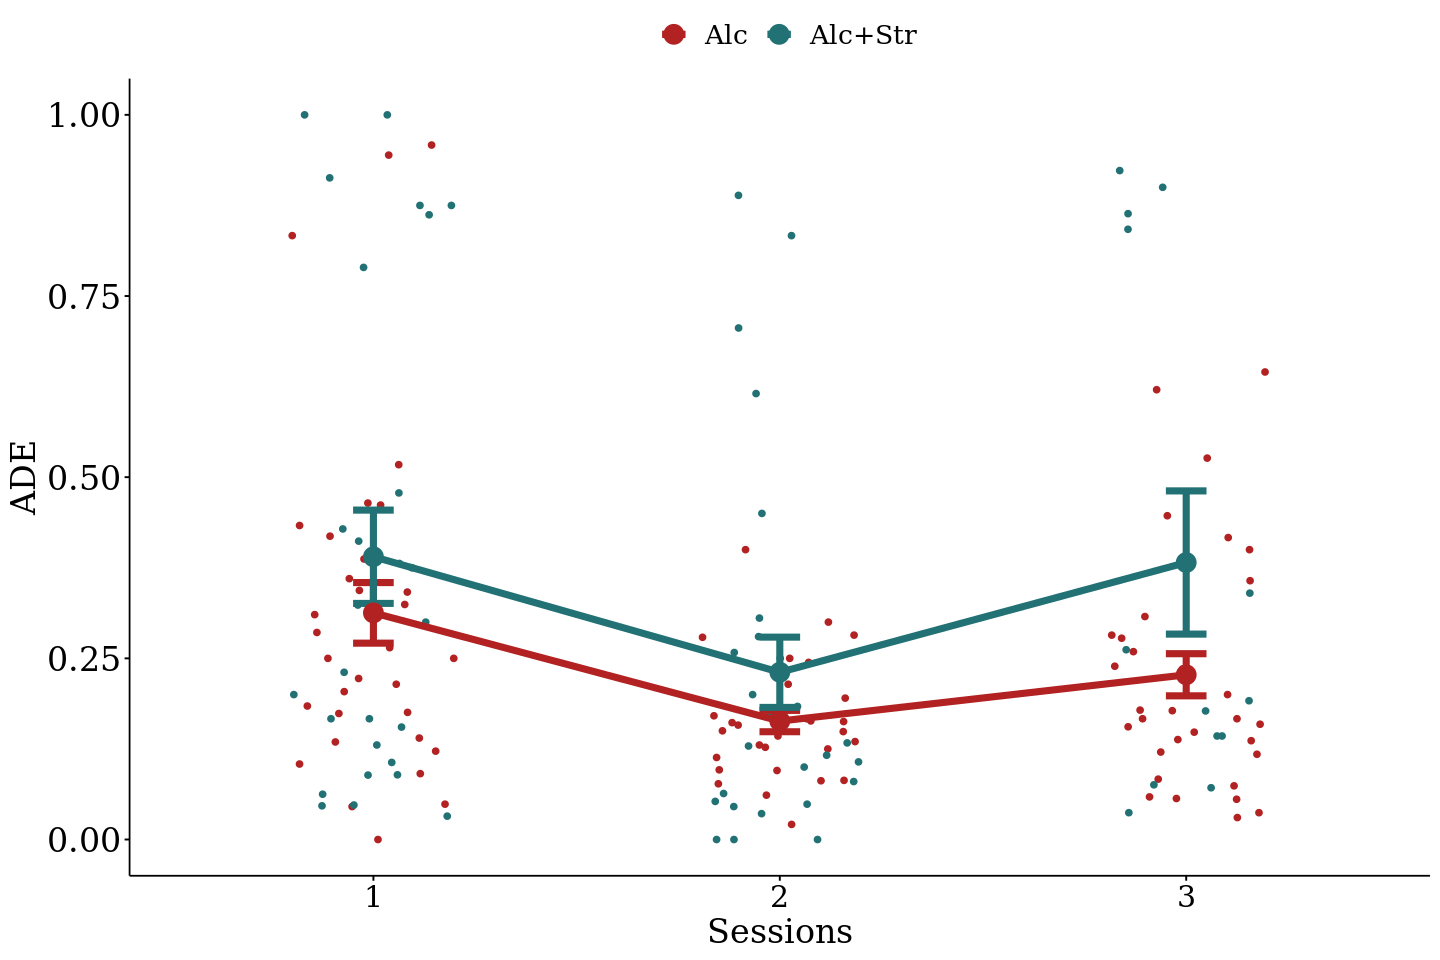

In [19]:
plot_ADE <- ggline(ADE, x = "Session", y =  "ADE", group = "Group",
              add = c("mean_se", "jitter"), point.size = 4, 
              size=2, color = "Group", palette = pal_group[2:3],
              xlab = "Sessions", ylab = "ADE") + theme_settings
plot_ADE

#### **5.4 Blood Ethanol Concentration**

In [ ]:
BEC_female <- ggscatter(BEC %>% filter(Sex == "Female"), x = "g/kg/240min", y = "BEC (ng/ul)",
 add = "reg.line", conf.int = TRUE, color = pal_sex[1], add.params = list(color = pal_sex[1], fill = "lightgray")) + 
 stat_cor() + theme_settings

In [ ]:
BEC %>% filter(Sex == "Female") %>% summary()

In [ ]:
BEC_male <- ggscatter(BEC %>% filter(Sex == "Male"), x = "g/kg/240min", y = "BEC (ng/ul)",
 add = "reg.line", conf.int = TRUE, color = pal_sex[2], add.params = list(color = pal_sex[2], fill = "lightgray")) + 
 stat_cor() + theme_settings

In [ ]:
BEC %>% filter(Sex == "Male") %>% summary()

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


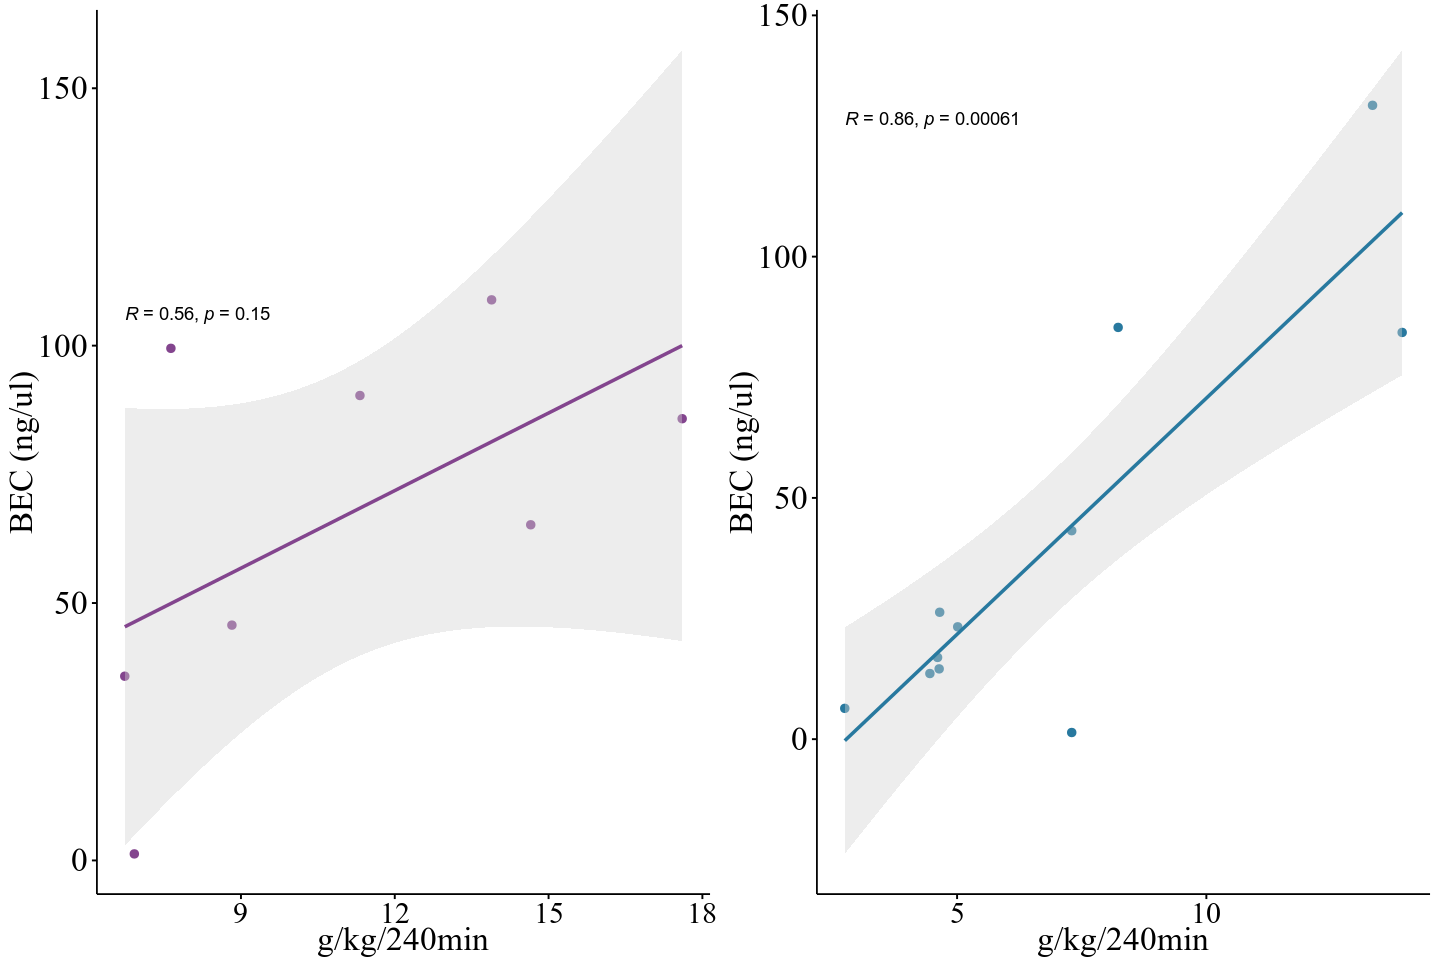

In [ ]:
ggarrange(BEC_female,BEC_male)

#### **5.4 Preferency index**

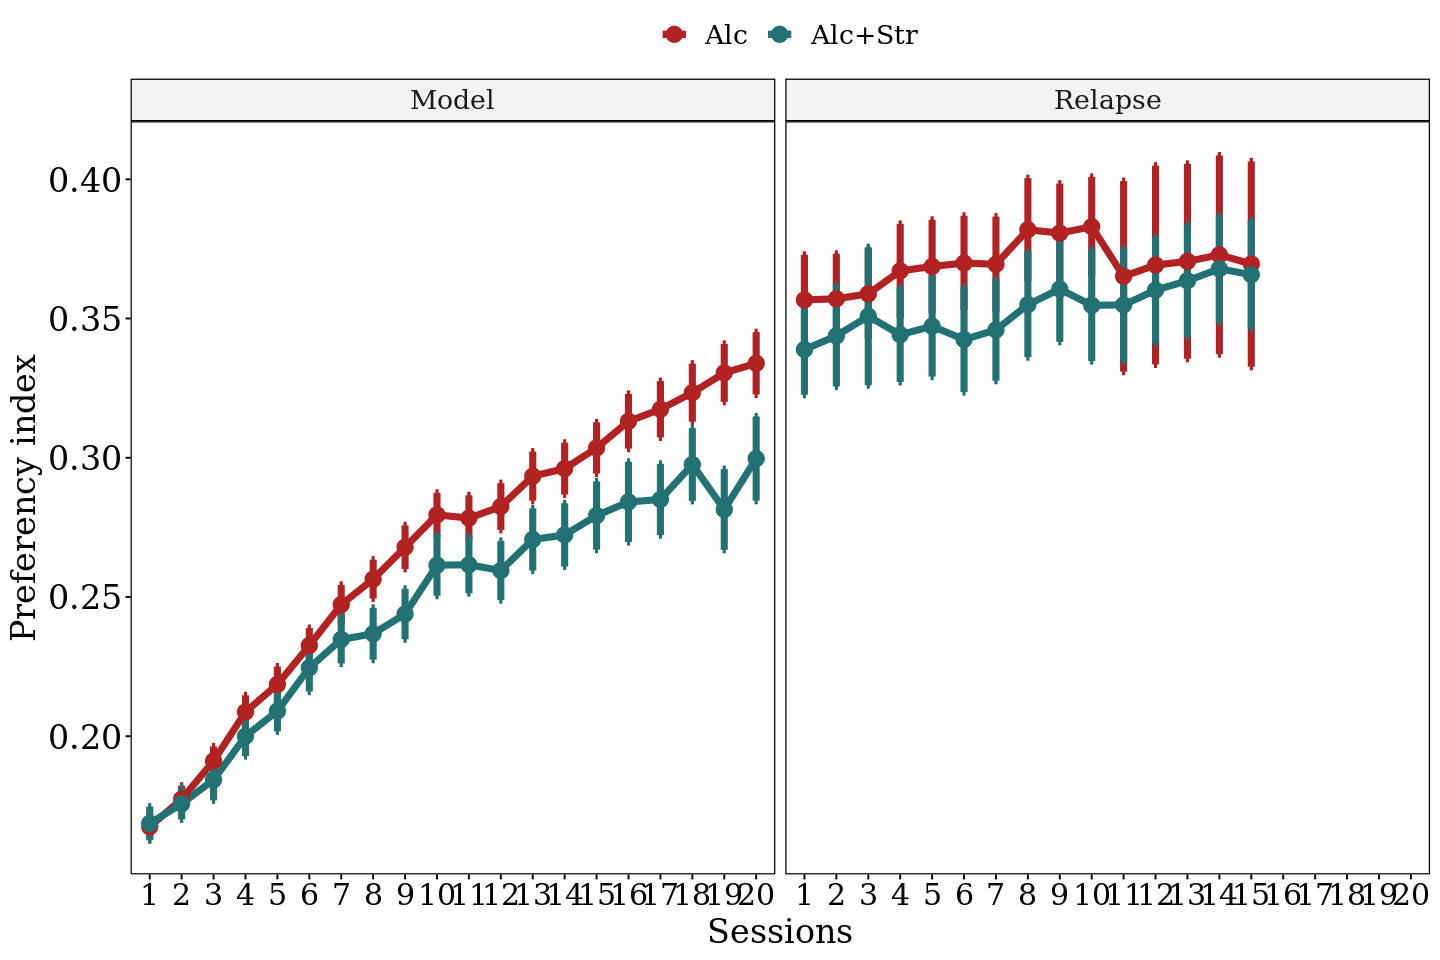

In [21]:
plot_class_preferency <- Alcohol_intake %>% ggline(x = "Session", y =  "Preferency", group = "Group", point.size = 3,
           add = c("mean_se"), size=2, color = "Group", facet.by = "Phase", palette = pal_group[2:3],
           legend.title = "Group", 
           ylab = "Preferency index", xlab = "Sessions") + theme_settings
plot_class_preferency

### **5.5 Weight**

In [22]:
Alcohol_intake <- Alcohol_intake %>%
    group_by(RID) %>%
    mutate(Weight_change = Weight_kg - first(Weight_kg), .after = "Weight_kg")    


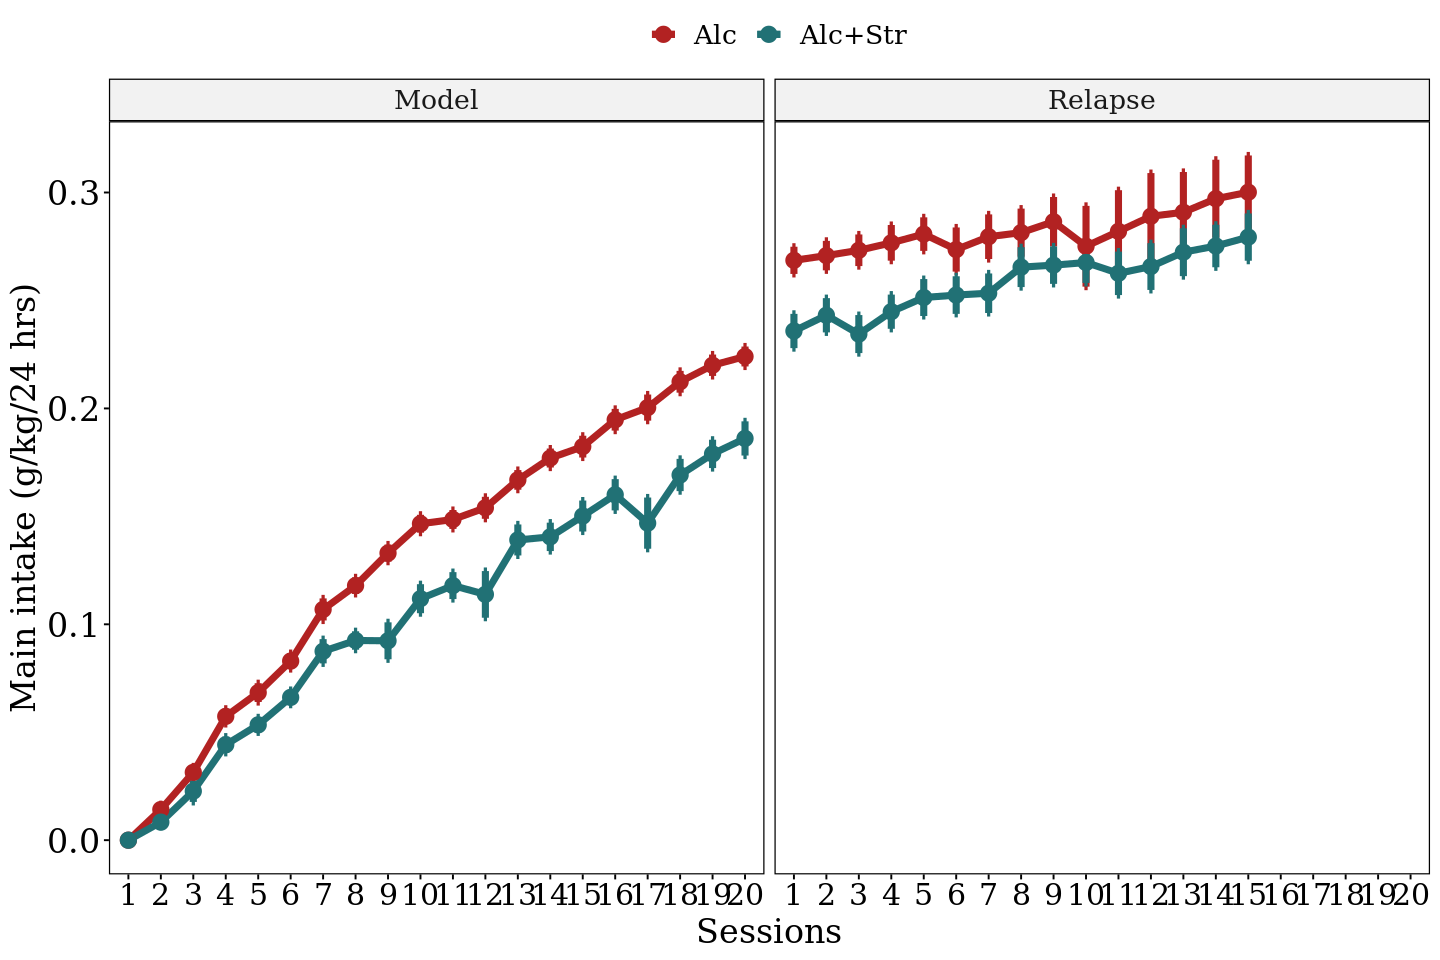

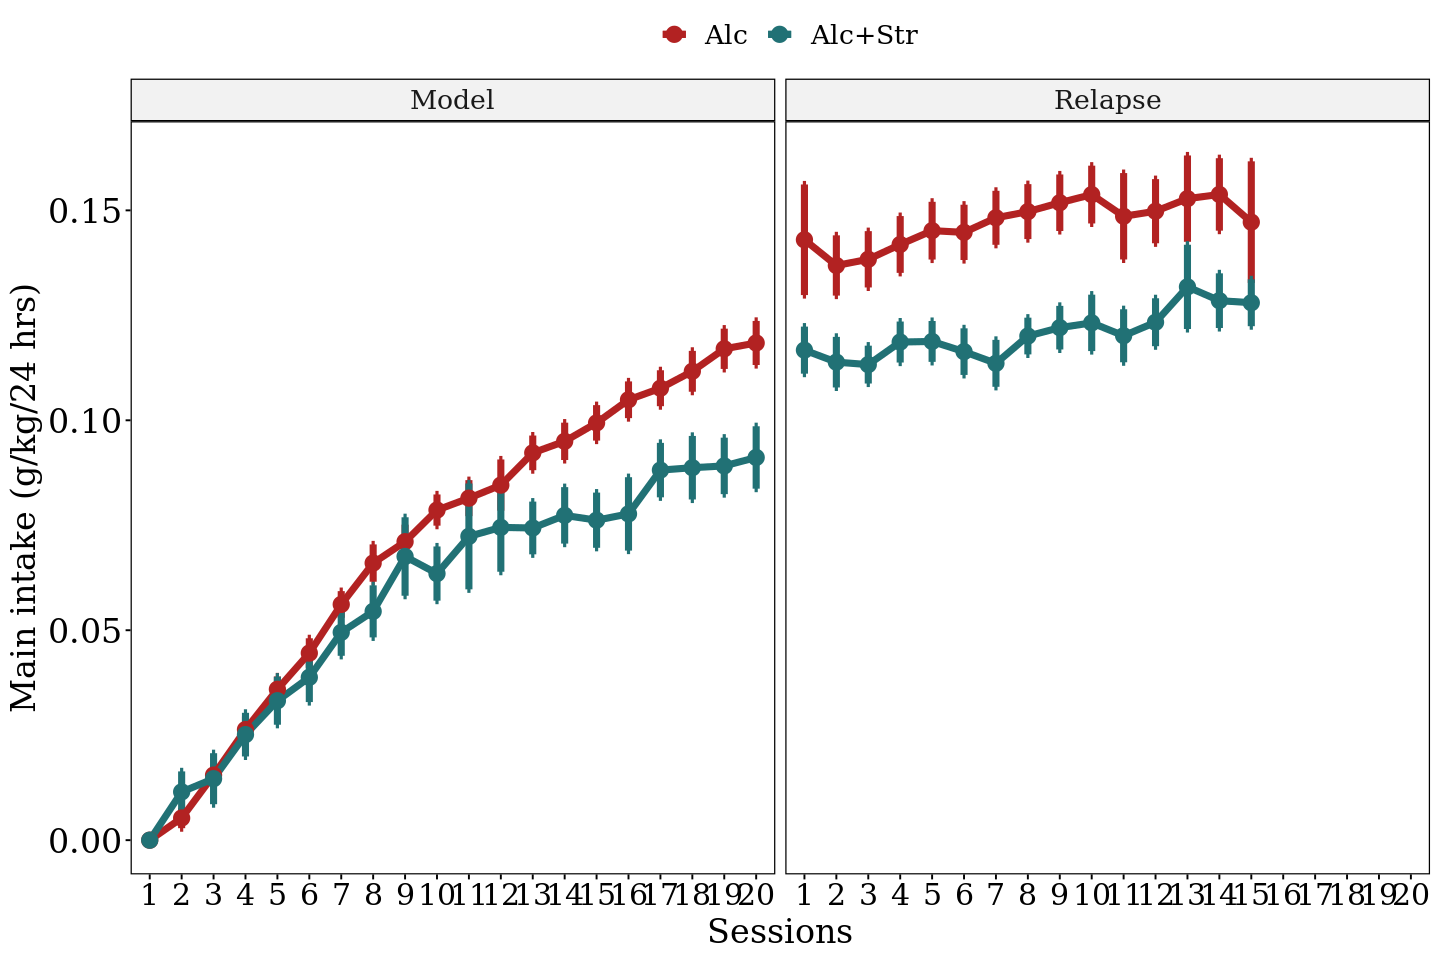

In [23]:
Alcohol_intake %>% filter(Sex == "male") %>%
    ggline(x = "Session", y =  "Weight_change", group = "Group", point.size = 3,
           add = c("mean_se"), size=2, color = "Group", facet.by = "Phase", palette = pal_group[2:3],
           legend.title = "Group", 
           ylab = "Main intake (g/kg/24 hrs)", xlab = "Sessions") + theme_settings 

Alcohol_intake %>% filter(Sex == "female") %>%
    ggline(x = "Session", y =  "Weight_change", group = "Group", point.size = 3,
           add = c("mean_se"), size=2, color = "Group", facet.by = "Phase", palette = pal_group[2:3],
           legend.title = "Group", 
           ylab = "Main intake (g/kg/24 hrs)", xlab = "Sessions") + theme_settings

## **6. Export data**

In [24]:
save(Alcohol_intake,General_intake,theme_settings,
     file = paste0(getwd(),"/Data/Alcohol_consumption.RData"))